# DeepEurovoc

The aim of this little experiment is to predict Eurovoc categories/fields of publications based on expression abstracts published by the PO. 

The model used in this notebook is based on the 1D CNN described in the Keras blog article https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html. It uses pre-trained GloVe word embeddings for text classification.

The input data is retrieved from the public SPARQL endpoint of the PO which is available at http://publications.europa.eu/webapi/rdf/sparql. The following query does the job:

The input data has already been downloaded and is stored in data.csv. Before loading the data, the modules needed throughout this notebook are imported.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Dropout
from keras import regularizers

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

AttributeError: module 'numpy' has no attribute '__version__'

Definition of some global variables used in this notebook:

In [ ]:
CLEANUP_DATA = False # save time by loading a cleaned up version from disc
MAX_NUM_WORDS = 20000 # max. size of vocabulary
EMBEDDING_DIM = 100 # dimension of GloVe word embeddings
MAX_SEQUENCE_LENGTH = 1000 # truncate examples after MAX_SEQUENCE_LENGTH words
VALIDATION_SPLIT = 0.2 # ration for split of training data and test data
NUM_EPOCHS = 1 # number of epochs the network is trained
# those are the eurovoc fields we want to support
EUROVOC_FIELDS = {
"4":  "POLITICS",
"8":  "INTERNATIONAL RELATIONS", 
"10": "EUROPEAN UNION",
"12": "LAW ",
"16": "ECONOMICS",
"20": "TRADE",
"24": "FINANCE",
"28": "SOCIAL QUESTIONS",
"32": "EDUCATION AND COMMUNICATIONS",
"36": "SCIENCE",
"40": "BUSINESS AND COMPETITION",
"44": "EMPLOYMENT AND WORKING CONDITIONS",
"48": "TRANSPORT",
"52": "ENVIRONMENT",
"56": "AGRICULTURE, FORESTRY AND FISHERIES",
"60": "AGRI-FOODSTUFFS",
"64": "PRODUCTION, TECHNOLOGY AND RESEARCH",
"66": "ENERGY",
"68": "INDUSTRY",
"72": "GEOGRAPHY",
"76": "INTERNATIONAL ORGANISATIONS"
}

Load the data and get some numbers...

In [ ]:
data_df = pd.read_csv("data.csv")
print(data_df.info())

We define a function that will help us to extract the abstracts as plain text from the XMLLiterals returned by Virtuoso, to remove all non-English words including stop words, and to perform lemmatization on the filtered words.

In [ ]:
def cleanup_abstract(xmlstring):
    #import ipdb; ipdb.set_trace()
    xmlstring = xmlstring.replace('""', '"')
    text = None
    try: 
        tree = ET.ElementTree(ET.fromstring(xmlstring))
        xpath_result = tree.findall(".//description")
        text = xpath_result[0].text
    except:
        text = xmlstring
    # remove stopwords and punctuation. lower case everything
    #stop_words = set(stopwords.words('english'))
    #tokens = word_tokenize(text)
    #tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and wordnet.synsets(w)]
    # lemmatize
    #lemma = WordNetLemmatizer()
    #final_tokens = []
    #for word in tokens:
    #    final_tokens.append(lemma.lemmatize(word))
    #ret = " ".join(final_tokens)
    #return ret
    return text

Cleaning the data involves two steps:

1\. processing of the abstracts 

2\. transform the ";" separated eurovoc codes in the concepts column into lists of eurovoc categories. Only consider to first two digits of the eurovoc codes. The total number of codes  in the data set is much too high (>5000) for classification. Therefore, the first two digits indicating the "subject matter" are extracted and filtered based on EUROVOC_FIELDS.

In [2]:
if CLEANUP_DATA:
    data_df["clean_abstract"] = data_df["abstract"].apply(cleanup_abstract)
    data_df["clean_concepts"] = data_df["concepts"].apply(lambda x: list({c[c.rfind("/")+1:c.rfind("/")+3] for c in x.split(";") if c[c.rfind("/")+1:c.rfind("/")+3] in EUROVOC_FIELDS}))
    data_df = data_df[data_df.astype(str)['clean_concepts'] != '[]']
    data_df.drop(["abstract"], axis=1)
    data_df.drop(["concepts"], axis=1)
    data_df.to_pickle("data_df.pkl")

NameError: name 'CLEANUP_DATA' is not defined

The next line loads the cleaned up data directly from file instead of computing it everytime the notebook is executed.

In [3]:
data_df = pd.read_pickle("data_df.pkl")
print(data_df['clean_abstract'][:5])
print(data_df['clean_concepts'][:5])

NameError: name 'pd' is not defined

We must convert the data set labels to numbers so that they can be processed by Keras. The approach is described in https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/.

In [4]:
labels = data_df["clean_concepts"].tolist()
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

NameError: name 'data_df' is not defined

A small test to make sure that MultiLabelBinarizer is really generating multi-label vectors and not just one-hot vectors.

In [5]:
print("Labels of the 2nd training example: " + str(mlb.inverse_transform(np.array([labels[1]]))))

NameError: name 'mlb' is not defined

Next we need to tranform the input examples into an array of numbers:

In [6]:
data = data_df["clean_abstract"].tolist()
tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

NameError: name 'data_df' is not defined

Split data into training data and test data.

In [24]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
#num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
#print(num_validation_samples)
#trainX = data[:-num_validation_samples]
#trainY = labels[:-num_validation_samples]
#testX = data[-num_validation_samples:]
#testY = labels[-num_validation_samples:]

#print("trainX.shape", trainX.shape)
#print("trainY.shape", trainY.shape)
#print("testX.shape", testX.shape)
#print("testY.shape", testY.shape)

Load the pre-computed GloVe word embeddings from file and create an embeddings_index:

In [25]:
embeddings_index = {}
with open(os.path.join('glove.6B', 'glove.6B.100d.txt'), 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Use word_index and embedding_index to compute the embedding_matrix. embedding_matrix is  a matrix storing the embedded_vector for each word in the data set. 

In [26]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    #else:
    #    print("Not not in embedding index: " + word)

Build an Keras embedding_layer. Note that trainable=false, i.e., weights are not getting updated. 

In [27]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Let's define the 1D convolutional model.

In [ ]:
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('tessstttyyy.png', dpi=100)


x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
data = np.column_stack((x, y))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               figsize=(8, 4))

ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.hist(data, bins=np.arange(data.min(), data.max()),
         label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()

Train on 25271 samples, validate on 6318 samples
Epoch 1/1
25271/25271 [==============================] - 239s 9ms/step - loss: 0.6158 - categorical_accuracy: 0.2381 - val_loss: 0.4412 - val_categorical_accuracy: 0.2657


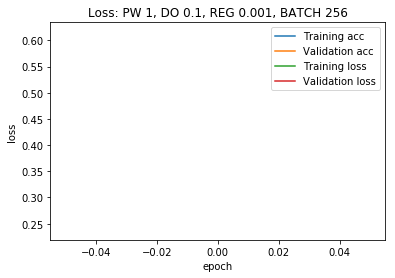

Train on 25271 samples, validate on 6318 samples
Epoch 1/1
23040/25271 [==========================>...] - ETA: 19s - loss: 2.1298 - categorical_accuracy: 0.2054

KeyboardInterrupt: 

In [28]:
for POS_WEIGHT in [1, 5, 10]:
    for DROPOUT in [0.1, 0.25, 0.5]:
        for REGULARIZATION in [0.001, 0.01, 0.1]:
            for BATCH_SIZE in [256]:
                
                params ={"pos_weight": str(POS_WEIGHT), 
                          "dropout": str(DROPOUT), 
                          "regularization": str(REGULARIZATION), 
                          "batch_size": str(BATCH_SIZE)}
                
                def weighted_binary_crossentropy(target, output):
                    """
                    Weighted binary crossentropy between an output tensor 
                    and a target tensor. POS_WEIGHT is used as a multiplier 
                    for the positive targets.

                    Combination of the following functions:
                    * keras.losses.binary_crossentropy
                    * keras.backend.tensorflow_backend.binary_crossentropy
                    * tf.nn.weighted_cross_entropy_with_logits
                    """
                    # transform back to logits
                    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
                    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
                    output = tf.log(output / (1 - output))
                    # compute weighted loss
                    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
                                                                    logits=output,
                                                                    pos_weight=POS_WEIGHT)
                    return tf.reduce_mean(loss, axis=-1)


                sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
                embedded_sequences = embedding_layer(sequence_input)
                x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZATION))(embedded_sequences)
                x = MaxPooling1D(5)(x)
                x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZATION))(x)
                x = MaxPooling1D(5)(x)
                x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZATION))(x)
                x = MaxPooling1D(35)(x)  # global max pooling
                x = Flatten()(x)
                x = Dropout(DROPOUT)(x)
                x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(REGULARIZATION))(x)
                x = Dropout(DROPOUT)(x)
                preds = Dense(labels.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(REGULARIZATION))(x)


                import keras.losses
                keras.losses.weighted_binary_crossentropy = weighted_binary_crossentropy

                model = Model(sequence_input, preds)
                model.compile(loss='weighted_binary_crossentropy',
                              optimizer='adam',
                              metrics=['categorical_accuracy'])

                history = model.fit(data, labels, validation_split=0.2,
                          epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
                
                model.save("model_%(pos_weight)s_%(dropout)s_%(regularization)s_%(batch_size)s.h5"%params)
                
                acc = history.history['categorical_accuracy']
                val_acc = history.history['val_categorical_accuracy']
                loss = history.history['loss']
                val_loss = history.history['val_loss']

                epochs = range(len(acc))

                plt.plot(epochs, acc, label='Training acc')
                plt.plot(epochs, val_acc, label='Validation acc')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.title('Accuracy: PW %(pos_weight)s, DO %(dropout)s, REG %(regularization)s, BATCH %(batch_size)s'% params)
                plt.legend()
                
                plt.figure()

                plt.plot(epochs, loss, label='Training loss')
                plt.plot(epochs, val_loss, label='Validation loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.title('Loss: PW %(pos_weight)s, DO %(dropout)s, REG %(regularization)s, BATCH %(batch_size)s'%params)
                plt.legend()
                plt.show()
                #f.savefig("model_%(pos_weight)s_%(dropout)s_%(regularization)s_%(batch_size)s.png"%params)

Now the model needs to be trained.

Save the model to disc!

Predict using an example from the training set. Later we should also create a dev set for prediction.